In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

tracking_uri = "../logs/mlruns"
os.makedirs(os.path.join(tracking_uri, ".trash"), exist_ok=True)

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("house_price_prediction")


C:\Users\LaurynasBaltrusaitis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Experiment: artifact_location=('file:///c:/Users/LaurynasBaltrusaitis/OneDrive - Adaptfy '
 'BV/Desktop/Education/git_personal_repos/house_price_prediction_project/notebooks/../logs/mlruns/436920743824240539'), creation_time=1758608845292, experiment_id='436920743824240539', last_update_time=1758608845292, lifecycle_stage='active', name='house_price_prediction', tags={}>

In [2]:
import sys
import os
from pathlib import Path
import yaml


# Adjust the path to your project root folder
project_root = os.path.abspath(
    os.path.join("..")
)  # from notebooks/ up one level

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_loading.data_loading.data_loader import load_data_from_json
from src.data_loading.preprocessing.preprocessing import preprocess_df
from src.data_loading.preprocessing.imputation import impute_missing_values


# go two levels up from notebook dir -> project root
ROOT = (
    Path(__file__).resolve().parents[2]
    if "__file__" in globals()
    else Path.cwd().parents[1]
)
CONFIG_PATH = (
    ROOT
    / "house_price_prediction_project"
    / "config"
    / "preprocessing_config.yaml"
)

with open(CONFIG_PATH) as f:
    CONFIG = yaml.safe_load(f)

df_raw = load_data_from_json("../data/parsed_json/*.json")
df_clean = preprocess_df(
    df_raw,
    drop_raw=CONFIG["preprocessing"]["drop_raw"],
    numeric_cols=CONFIG["preprocessing"]["numeric_cols"],
)
df_clean = impute_missing_values(
    df_clean, CONFIG["preprocessing"]["imputation"]
)
# Drop price_num NaNs for the training of the model
df_clean = df_clean[df_clean["price_num"].notna()]
df_clean.drop(columns=["living_area"], inplace=True)


# df_clean = df_clean[:100] 
df = df_clean.copy()

In [3]:
from src.features.data_prep_for_modelling.data_preparation import prepare_data

FEATURES_CONFIG_PATH = (
    ROOT / "house_price_prediction_project" / "config" / "model_config.yaml"
)

# Scaled features (applies scaling according to YAML)
X_train_scaled, X_test_scaled, y_train, y_test, X_val, y_val, scaler, _ = prepare_data(
    df,
    config_path=FEATURES_CONFIG_PATH,
    model_name="linear_regression",  # uses the unified YAML key
    use_extended_features=False,       # set True if you want extended features
    cv=False
)

In [4]:
from src.model.evaluate import ModelEvaluator
from src.model.mlflow_logger import MLFlowLogger

evaluator = ModelEvaluator()
logger = MLFlowLogger()

lr_model = LinearRegression()

# Evaluate
trained_lr, y_train_pred, y_val_pred, y_test_pred, lr_results = evaluator.evaluate(
    model=lr_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_params={},   
    fit_params={},     
    use_xgb_train=False
)

# Log the model and results
logger.log_model(trained_lr, "LinearRegression", lr_results)

2025/10/07 15:21:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 15:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression -> {'train_rmse': 234668.57892918427, 'test_rmse': 247683.63844482793, 'train_mae': 133680.6268753051, 'test_mae': 135313.49701588583, 'train_r2': 0.7993796779769898, 'test_r2': 0.7353680437834911, 'train_mape': 21.828819871459384, 'test_mape': 21.525239863141383, 'train_huber': 133680.1268753051, 'test_huber': 135312.99701588583}


In [5]:
FEATURES_AND_MODEL_CONFIG_PATH = (
    ROOT
    / "house_price_prediction_project"
    / "config"
    / "model_config.yaml"
)
# --- Prepare data for final modeling ---
X_train, X_test, y_train, y_test, X_val, y_val, scaler, feature_encoders = prepare_data(
    df=df_clean,
    config_path=FEATURES_AND_MODEL_CONFIG_PATH,
    model_name="xgboost_early_stopping",  
    use_extended_features=True,           
    cv=False                              
)


print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape if X_val is not None else None)
print("Test shape:", X_test.shape)

Train shape: (3008, 66)
Validation shape: (430, 66)
Test shape: (860, 66)


#### Without LOG

In [6]:
X_train_final = X_train.copy()
X_test_final = X_test.copy()
X_val_final = X_val.copy()

print("Train shape:", X_train_final.shape)
print("validation shape:", X_val_final.shape)
print("Test shape:", X_test_final.shape)

Train shape: (3008, 66)
validation shape: (430, 66)
Test shape: (860, 66)


In [7]:
# XGBoost with log-transform

from functools import partial
from src.model.objectives_optuna import unified_objective

FEATURES_AND_MODEL_CONFIG_PATH = (
    ROOT
    / "house_price_prediction_project"
    / "config"
    / "model_config.yaml"
)

sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_xgb = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

objective_xgb_partial = partial(
    unified_objective,
    model_name="xgboost_early_stopping_optuna_feature_eng",
    df=df_clean,
    features_config=FEATURES_AND_MODEL_CONFIG_PATH,
    model_config=FEATURES_AND_MODEL_CONFIG_PATH,
    use_log=False,  
    n_splits=5,
    use_extended_features=True
)
study_xgb.optimize(objective_xgb_partial, n_trials=50)

# # Random Forest with log-transform
# study_rf = optuna.create_study(direction="minimize")

# objective_rf_partial = partial(
#     unified_objective,
#     model_name="random_forest_optuna_feature_eng",
#     df=df_clean,
#     features_config=FEATURES_AND_MODEL_CONFIG_PATH,
#     model_config=FEATURES_AND_MODEL_CONFIG_PATH,
#     use_log=True,  
#     n_splits=5,
#     use_extended_features=True

# )

# study_rf.optimize(objective_rf_partial, n_trials=50)

[I 2025-10-02 07:57:39,915] A new study created in memory with name: no-name-1adf0fa7-b370-4807-bba6-4b52a2654e9f
[I 2025-10-02 07:57:43,135] Trial 0 finished with value: 166737.58107385118 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'eta': 0.1639196365086843, 'subsample': 0.8397987726295555, 'colsample_bytree': 0.7156018640442436, 'gamma': 0.015599452033620266, 'lambda': 0.034065852851773964, 'alpha': 0.1092940916619948, 'max_bin': 280}. Best is trial 0 with value: 166737.58107385118.
[I 2025-10-02 07:57:45,764] Trial 1 finished with value: 171816.37442887123 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'eta': 0.17819459112971964, 'subsample': 0.8748663961200633, 'colsample_bytree': 0.7212339110678276, 'gamma': 0.018182496720710064, 'lambda': 0.042838315689740364, 'alpha': 0.06433937943676302, 'max_bin': 276}. Best is trial 0 with value: 166737.58107385118.
[I 2025-10-02 07:57:48,817] Trial 2 finished with value: 174653.3215203632 and parameters: {'max_depth': 

In [8]:
# Initialize evaluator with log-transform if used
# evaluator = ModelEvaluator(target_transform=np.log1p, inverse_transform=np.expm1)

# # --- Random Forest ---
# best_rf = RandomForestRegressor(**study_rf.best_params)
# trained_rf, y_train_pred, y_val_pred, y_test_pred, results_rf = evaluator.evaluate(
#     model=best_rf,
#     X_train=X_train_final,
#     y_train=y_train,
#     X_test=X_test_final,
#     y_test=y_test,
#     X_val=X_val_final,
#     y_val=y_val,
#     use_xgb_train=False,
# )
# logger.log_model(trained_rf, "RF_LogTransform_Optuna_feature_eng", results_rf, use_xgb_train=False)

# --- XGBoost ---
best_xgb_params = study_xgb.best_params
trained_xgb, y_train_pred, y_val_pred, y_test_pred, results_xgb = evaluator.evaluate(
    model=None,  # not used in XGBoost.train
    X_train=X_train_final,
    y_train=y_train,
    X_test=X_test_final,
    y_test=y_test,
    X_val=X_val_final,
    y_val=y_val,
    use_xgb_train=True,
    model_params=best_xgb_params,  # <--- crucial
    fit_params={"num_boost_round": 1000, "early_stopping_rounds": 50},
)
logger.log_model(trained_xgb, "XGB_Optuna_LogTransformed_feature_eng", results_xgb, use_xgb_train=True)


2025/10/02 08:00:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\LaurynasBaltrusaitis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlflow\xgboost\__init__.py:169: UserWarning: [08:00:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/10/02 08:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGB_Optuna_LogTransformed_feature_eng -> {'train_rmse': 96884.55731806418, 'val_rmse': 200285.28220712594, 'test_rmse': 211269.9849992261, 'train_mae': 59030.820146276594, 'val_mae': 87276.87093023256, 'test_mae': 83697.62845203489, 'train_r2': 0.9656111154150373, 'val_r2': 0.8591305086524949, 'test_r2': 0.807458986917952, 'train_mape': 9.054941788351542, 'val_mape': 11.719100997580592, 'test_mape': 10.377477418762744, 'train_huber': 59030.320146276594, 'val_huber': 87276.37093023256, 'test_huber': 83697.12845203489}


### with LOG

In [9]:
# XGBoost with log-transform

from functools import partial
from src.model.objectives_optuna import unified_objective

FEATURES_AND_MODEL_CONFIG_PATH = (
    ROOT
    / "house_price_prediction_project"
    / "config"
    / "model_config.yaml"
)

sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study_xgb = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

objective_xgb_partial = partial(
    unified_objective,
    model_name="xgboost_early_stopping_optuna_feature_eng",
    df=df_clean,
    features_config=FEATURES_AND_MODEL_CONFIG_PATH,
    model_config=FEATURES_AND_MODEL_CONFIG_PATH,
    use_log=True,  
    n_splits=5,
    use_extended_features=True
)
study_xgb.optimize(objective_xgb_partial, n_trials=50)

# # Random Forest with log-transform
# study_rf = optuna.create_study(direction="minimize")

# objective_rf_partial = partial(
#     unified_objective,
#     model_name="random_forest_optuna_feature_eng",
#     df=df_clean,
#     features_config=FEATURES_AND_MODEL_CONFIG_PATH,
#     model_config=FEATURES_AND_MODEL_CONFIG_PATH,
#     use_log=True,  
#     n_splits=5,
#     use_extended_features=True

# )

# study_rf.optimize(objective_rf_partial, n_trials=50)

[I 2025-10-02 08:00:39,125] A new study created in memory with name: no-name-dca2651b-e192-49eb-9b17-d8b4764b3636
[I 2025-10-02 08:00:42,847] Trial 0 finished with value: 154747.2110356833 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'eta': 0.1639196365086843, 'subsample': 0.8397987726295555, 'colsample_bytree': 0.7156018640442436, 'gamma': 0.015599452033620266, 'lambda': 0.034065852851773964, 'alpha': 0.1092940916619948, 'max_bin': 280}. Best is trial 0 with value: 154747.2110356833.
[I 2025-10-02 08:00:45,767] Trial 1 finished with value: 164372.05463103522 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'eta': 0.17819459112971964, 'subsample': 0.8748663961200633, 'colsample_bytree': 0.7212339110678276, 'gamma': 0.018182496720710064, 'lambda': 0.042838315689740364, 'alpha': 0.06433937943676302, 'max_bin': 276}. Best is trial 0 with value: 154747.2110356833.
[I 2025-10-02 08:00:48,681] Trial 2 finished with value: 153846.45894216336 and parameters: {'max_depth': 4,

In [10]:
# Initialize evaluator with log-transform if used
evaluator = ModelEvaluator(target_transform=np.log1p, inverse_transform=np.expm1)

# # --- Random Forest ---
# best_rf = RandomForestRegressor(**study_rf.best_params)
# trained_rf, y_train_pred, y_val_pred, y_test_pred, results_rf = evaluator.evaluate(
#     model=best_rf,
#     X_train=X_train_final,
#     y_train=y_train,
#     X_test=X_test_final,
#     y_test=y_test,
#     X_val=X_val_final,
#     y_val=y_val,
#     use_xgb_train=False,
# )
# logger.log_model(trained_rf, "RF_LogTransform_Optuna_feature_eng", results_rf, use_xgb_train=False)

# --- XGBoost ---
best_xgb_params = study_xgb.best_params
trained_xgb, y_train_pred, y_val_pred, y_test_pred, results_xgb = evaluator.evaluate(
    model=None,  # not used in XGBoost.train
    X_train=X_train_final,
    y_train=y_train,
    X_test=X_test_final,
    y_test=y_test,
    X_val=X_val_final,
    y_val=y_val,
    use_xgb_train=True,
    model_params=best_xgb_params,  # <--- crucial
    fit_params={"num_boost_round": 1000, "early_stopping_rounds": 50},
)
logger.log_model(trained_xgb, "XGB_Optuna_LogTransformed_feature_eng", results_xgb, use_xgb_train=True)


2025/10/02 08:05:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\LaurynasBaltrusaitis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlflow\xgboost\__init__.py:169: UserWarning: [08:05:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/10/02 08:07:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGB_Optuna_LogTransformed_feature_eng -> {'train_rmse': 63073.18496411052, 'val_rmse': 160222.38765970862, 'test_rmse': 204220.13784317198, 'train_mae': 35335.66132500831, 'val_mae': 68760.72739825581, 'test_mae': 71715.29549418605, 'train_r2': 0.9854253379034243, 'val_r2': 0.909850095334676, 'test_r2': 0.82009435957279, 'train_mape': 5.232054723127423, 'val_mape': 8.825767266183316, 'test_mape': 8.249103951744118, 'train_huber': 35335.16132500831, 'val_huber': 68760.22739825581, 'test_huber': 71714.79549418605}



Top 10 features by mean weight across folds:
feature
log_size_num                   203.2
families_with_children_pct     169.2
inhabitants_in_neighborhood    151.6
size_per_luxury                135.4
contribution_vve_num           132.6
                               ...  
roof_type_Saddle                 2.6
has_lift                         2.2
has_airconditioning              1.4
num_luxury_facilities            1.2
has_domotica                     0.4
Name: mean, Length: 62, dtype: float64


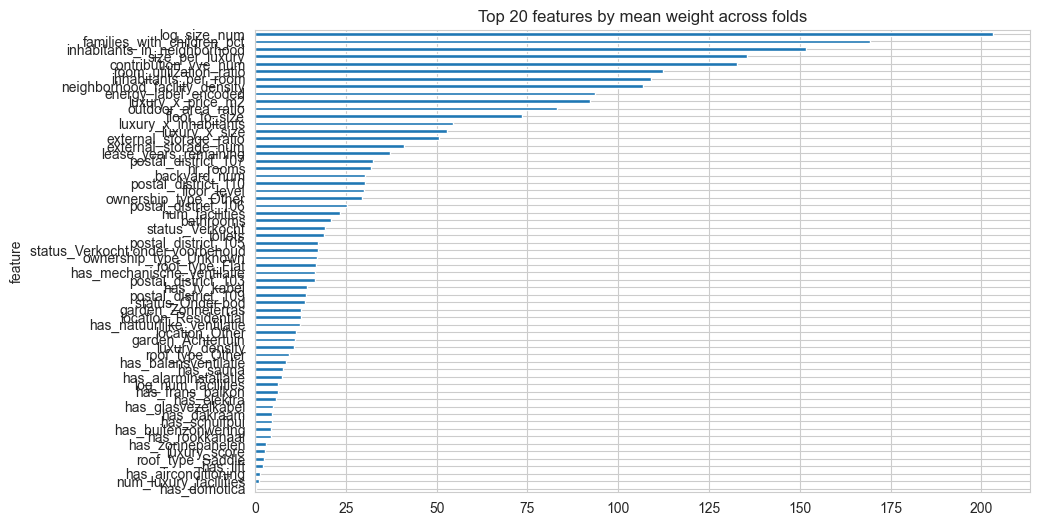


Top 10 features by mean gain across folds:
feature
log_size_num           9.287977
postal_district_110    2.912357
bathrooms              2.905097
postal_district_106    1.221600
luxury_x_price_m2      1.083125
                         ...   
has_elektra            0.045148
has_buitenzonwering    0.044766
has_airconditioning    0.026943
roof_type_Saddle       0.026602
has_domotica           0.017261
Name: mean, Length: 62, dtype: float64


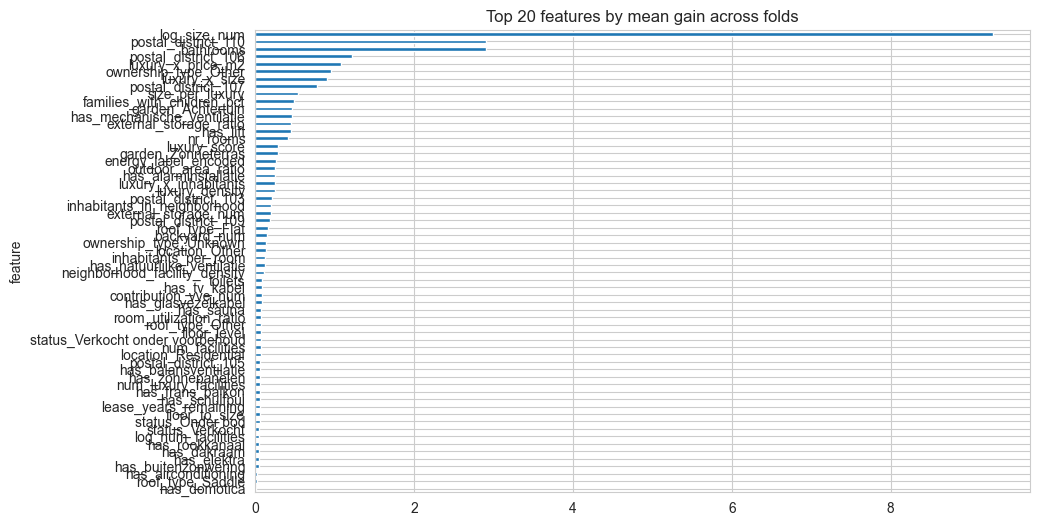


Top 10 features by mean cover across folds:
feature
has_alarminstallatie                2892.581348
has_sauna                           2838.300586
has_frans_balkon                    2515.680005
status_Verkocht                     2155.874487
status_Verkocht onder voorbehoud    2142.846680
                                       ...     
luxury_density                       672.988354
has_glasvezelkabel                   658.205548
has_tv_kabel                         523.245520
roof_type_Other                      279.159999
has_lift                             226.566666
Name: mean, Length: 62, dtype: float64


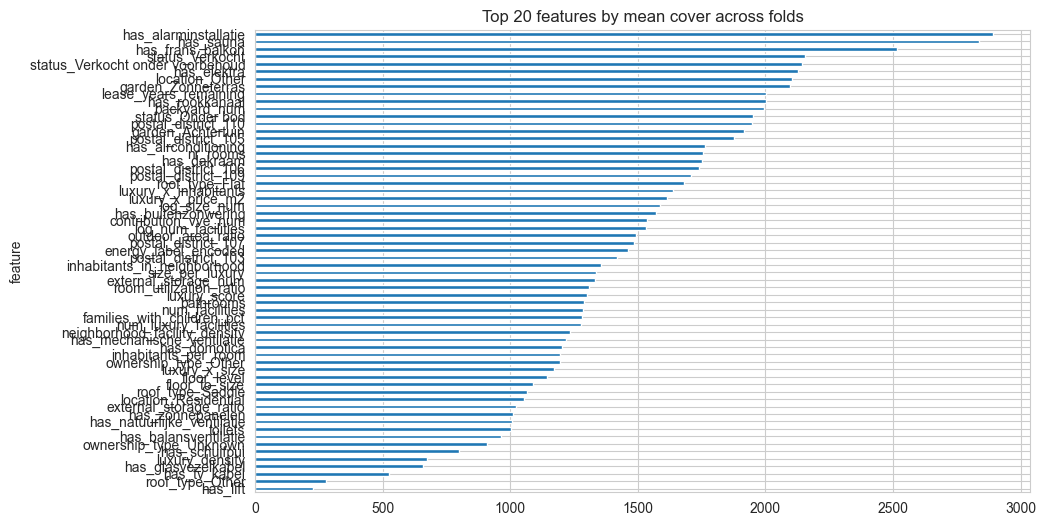

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np

from src.model.cv_helpers import prepare_base_data
from src.features.feature_engineering import feature_engineering_cv as fe_cv

prepare_fold_features = fe_cv.prepare_fold_features

# Number of folds (should match your CV setup)
N_SPLITS = 5

# Prepare base data (features + target)
X_full, y_full = prepare_base_data(df_clean, FEATURES_AND_MODEL_CONFIG_PATH, "xgboost_early_stopping_optuna_feature_eng")

importance_types = ["weight", "gain", "cover"]
fold_importances = {imp_type: [] for imp_type in importance_types}

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full), 1):
    X_train, X_val = X_full.iloc[train_idx].copy(), X_full.iloc[val_idx].copy()
    y_train, y_val = y_full.iloc[train_idx].copy(), y_full.iloc[val_idx].copy()
    
    # Prepare fold-wise features (ensure extended feature engineering matches training)
    X_train_fold, X_val_fold, _, _ = prepare_fold_features(X_train, X_val, use_extended_features=True)

    cols_to_drop = ["price_per_m2_neighborhood", "size_num"]  # or just one of them
    X_train_fold = X_train_fold.drop(columns=cols_to_drop, errors="ignore")
    X_val_fold = X_val_fold.drop(columns=cols_to_drop, errors="ignore")
    
    # Train XGBoost on this fold using best params
    dtrain = xgb.DMatrix(X_train_fold, label=np.log1p(y_train))
    dval = xgb.DMatrix(X_val_fold, label=np.log1p(y_val))
    
    model_fold = xgb.train(
        params=best_xgb_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # Collect importance for each type
    for imp_type in importance_types:
        imp_dict = model_fold.get_score(importance_type=imp_type)
        df_imp = pd.DataFrame.from_dict(imp_dict, orient="index", columns=[imp_type])
        df_imp.index.name = "feature"
        fold_importances[imp_type].append(df_imp)

# --- Aggregate across folds ---
agg_importances = {}
for imp_type, dfs in fold_importances.items():
    # Combine all folds into a single dataframe
    df_all = pd.concat(dfs, axis=1).fillna(0)
    df_all["mean"] = df_all.mean(axis=1)
    df_all = df_all.sort_values(by="mean", ascending=False)
    agg_importances[imp_type] = df_all
    print(f"\nTop 10 features by mean {imp_type} across folds:")
    print(df_all["mean"].head(100))
    
    # Plot top 20
    df_all["mean"].head(200).plot.barh(figsize=(10,6), title=f"Top 20 features by mean {imp_type} across folds")
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
import shap

fold_shap_values = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full), 1):
    X_train, X_val = X_full.iloc[train_idx].copy(), X_full.iloc[val_idx].copy()
    y_train, y_val = y_full.iloc[train_idx].copy(), y_full.iloc[val_idx].copy()
    
    # Prepare fold-wise features
    X_train_fold, X_val_fold, _, _ = prepare_fold_features(X_train, X_val, use_extended_features=True)
    cols_to_drop = ["price_per_m2_neighborhood", "size_num"]  # or just one of them
    X_train_fold = X_train_fold.drop(columns=cols_to_drop, errors="ignore")
    X_val_fold = X_val_fold.drop(columns=cols_to_drop, errors="ignore")
    
    # Train XGBoost Booster
    dtrain = xgb.DMatrix(X_train_fold, label=np.log1p(y_train))
    dval = xgb.DMatrix(X_val_fold, label=np.log1p(y_val))
    
    model_fold = xgb.train(
        params=best_xgb_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # SHAP for Booster
    explainer = shap.TreeExplainer(model_fold)
    shap_values = explainer.shap_values(dval)  # DMatrix
    
    # Store mean absolute SHAP values per feature for this fold
    fold_shap_values.append(pd.DataFrame({
        "feature": X_val_fold.columns,
        "mean_abs_shap": np.abs(shap_values).mean(axis=0)
    }))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.1)

# Combine all folds
df_shap_all = pd.concat(fold_shap_values)

# Group by feature and compute mean across folds
agg_shap = df_shap_all.groupby("feature")["mean_abs_shap"].mean().sort_values(ascending=False)

print("\nTop 10 features by mean absolute SHAP value across folds:")
print(agg_shap.head(10))

# Prepare data
top_features = agg_shap.head(10).sort_values()
features = top_features.index
shap_values = top_features.values
models = np.arange(len(features))
bar_width = 0.6
color = 'skyblue'

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bar plot
ax.barh(models, shap_values, height=bar_width, color=color)

# Y-axis labels
ax.set_yticks(models)
ax.set_yticklabels(features)
ax.invert_yaxis()  # highest SHAP on top

# Labels and title
ax.set_xlabel("Mean Absolute SHAP Value")
ax.set_title("Top 10 Features by SHAP Value")

# Add value labels
for i, val in enumerate(shap_values):
    ax.text(val + 0.01 * max(shap_values), i, f"{val:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Combine all folds
df_shap_all = pd.concat(fold_shap_values)

# Group by feature and compute mean across folds
agg_shap = df_shap_all.groupby("feature")["mean_abs_shap"].mean().sort_values(ascending=False)

print("\nTop 20 features by mean absolute SHAP value across folds:")
print(agg_shap.head(10))

# Plot
agg_shap.head(10).sort_values().plot.barh(figsize=(10,6), title="Top 10 features by SHAP value")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

def shap_to_euros(model, X, shap_values_array, target_transform_inverse=np.expm1):
    """
    Convert SHAP values from log1p scale to original price scale.

    Args:
        model: trained XGBoost model (xgb.Booster)
        X: pd.DataFrame, features used for prediction
        shap_values_array: numpy array of SHAP values (n_samples, n_features)
        target_transform_inverse: function to revert log1p, default np.expm1

    Returns:
        pd.Series: mean absolute SHAP contributions in euros per feature
    """
    # Predict log1p(price) for each sample
    dmatrix = xgb.DMatrix(X)
    pred_log = model.predict(dmatrix)  # log1p(price)
    
    # Approximate contribution in original price units
    # delta_euros = exp(pred + shap) - exp(pred)
    price_contrib = np.expm1(pred_log[:, None] + shap_values_array) - np.expm1(pred_log[:, None])
    
    # Convert to DataFrame for convenience
    df_shap_euros = pd.DataFrame(price_contrib, columns=X.columns)
    
    # Mean absolute contribution per feature
    mean_abs_euros = df_shap_euros.abs().mean().sort_values(ascending=False)
    
    return mean_abs_euros

# Example usage:
mean_abs_shap_euros = shap_to_euros(model_fold, X_val_fold, shap_values.values if hasattr(shap_values, "values") else shap_values)
print("Top 20 features by SHAP contribution in euros:")
print(mean_abs_shap_euros.head(10))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.1)

# Top 10 features
top_features = mean_abs_shap_euros.head(10).sort_values()
features = top_features.index
shap_values = top_features.values
models = np.arange(len(features))
bar_width = 0.6
color = 'skyblue'

# Friendly feature names
feature_rename = {
    "log_size_num": "Property Size (log m²)",
    "log_price_per_m2_neighborhood": "Price per m² by Neighborhood (log €)",
    "nr_rooms": "Number of Rooms",
    "bathrooms": "Number of Bathrooms",
    "energy_label_encoded": "Energy Label",
    "postal_district_110": "Postal District 110",
    "garden_None": "No Garden",
    "room_utilization_ratio": "Room Utilization Ratio",
    "neighborhood_facility_density": "Neighborhood Amenities Density",
    "num_facilities": "Number of Facitilies"
}

# Notes dictionary
notes_dict = {
    "log_size_num": "Larger homes dominate price predictions.",
    "log_price_per_m2_neighborhood": "Captures local market variation.",
    "nr_rooms": "More rooms generally increase price.",
    "bathrooms": "Bathrooms add significant value.",
    "energy_label_encoded": "Energy efficiency materially affects price.",
    "postal_district_110": "Micro-location matters.",
    "garden_None": "Lack of a garden slightly lowers value.",
    "room_utilization_ratio": "Efficient space usage boosts price per m².",
    "neighborhood_facility_density": "Access to amenities increases home value.",
    "num_facilities": "Larger number of facilities increases the price."

}

# Map friendly names
friendly_names = [feature_rename.get(f, f) for f in features]

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))  # wider for notes

# Horizontal bar plot
bars = ax.barh(models, shap_values, height=bar_width, color=color)

# Y-axis labels (friendly names)
ax.set_yticks(models)
ax.set_yticklabels(friendly_names)
ax.invert_yaxis()  # highest SHAP on top

# Labels and title
ax.set_xlabel("Mean Absolute SHAP Contribution (€)")
ax.set_title("Top 10 Features by SHAP Contribution in Euros")

# Determine far-right position for notes (outside all bars)
note_x = max(shap_values) * 1.15

# Add value labels on bars and notes in boxes on the right
for i, bar in enumerate(bars):
    val = bar.get_width()
    # Bar value
    ax.text(val + max(shap_values)*0.01, i, f"€{val:,.0f}", va='center', fontsize=10)
    
    # Note, if exists
    note = notes_dict.get(features[i], "")
    if note:
        ax.text(note_x, i, note, va='center', ha='left', fontsize=9,
                color='black', fontstyle='italic',
                bbox=dict(facecolor='lightgray', alpha=0.3, boxstyle='round,pad=0.3'))

# Extend x-limits to fit notes
ax.set_xlim(0, note_x * 1.05)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

sns.set(style="whitegrid", font_scale=1.1)

# Sort trials by number
trials = sorted(study_xgb.trials, key=lambda t: t.number)
trial_numbers = [t.number for t in trials]
objective_values = [t.value for t in trials]

# Compute best-so-far values
best_so_far = []
current_best = float('inf')  # minimizing objective
best_trial_index = 0
for i, value in enumerate(objective_values):
    if value < current_best:
        current_best = value
        best_trial_index = i
    best_so_far.append(current_best)

# Best trial info
best_trial = trials[best_trial_index]
best_params = best_trial.params
best_value = best_trial.value

# Round numeric parameters to 3 decimals
param_text = "\n".join([f"{k}: {round(v,3) if isinstance(v,(int,float)) else v}" 
                        for k, v in best_params.items()])

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Scatter trial values
ax.scatter(trial_numbers, objective_values, color='skyblue', label='Trial Values', edgecolor='k')

# Best-so-far line
ax.plot(trial_numbers, best_so_far, color='red', linewidth=2, label='Best-So-Far')

# Highlight best trial
ax.scatter(best_trial.number, best_value, color='green', s=150, marker='*', label='Best Trial', edgecolor='k')

# Annotate best trial with a box
ax.annotate(f'Best Trial #{best_trial.number}\nValue: {best_value:.4f}\n{param_text}',
            xy=(best_trial.number, best_value),
            xytext=(best_trial.number + 0.5, best_value + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.4),
            fontsize=10)

# Labels and title
ax.set_xlabel('Trial Number')
ax.set_ylabel('Objective Value')
ax.set_title('Optuna XGBoost Optimization Convergence')

# Legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid", font_scale=1.1)

# Compute residuals
residuals = y_test - y_test_pred

# Define extreme outliers: top 5% of absolute residuals
threshold = np.percentile(np.abs(residuals), 95)
outliers_mask = np.abs(residuals) >= threshold

plt.figure(figsize=(10, 7))

# Plot normal listings
plt.scatter(
    y_test[~outliers_mask],
    y_test_pred[~outliers_mask],
    alpha=0.5,
    color='skyblue',
    label="Normal listings",
    edgecolor='k'
)

# Plot extreme residuals
plt.scatter(
    y_test[outliers_mask],
    y_test_pred[outliers_mask],
    color="red",
    label="Extreme listings",
    edgecolor='k'
)

# Diagonal line (perfect prediction)
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val], color="black", linestyle="--", label="Perfect prediction")

# Annotate a few largest outliers by absolute residual
num_annotations = 5
outliers_df = pd.DataFrame({
    'y_true': y_test[outliers_mask],
    'y_pred': y_test_pred[outliers_mask],
    'residual': residuals[outliers_mask],
    'size': X_test.loc[outliers_mask, 'size_num']  # replace 'size' with your feature name
})
outliers_df['abs_residual'] = np.abs(outliers_df['residual'])
top_outliers = outliers_df.nlargest(num_annotations, 'abs_residual').copy()

# Initialize annotation positions slightly offset
top_outliers['x_offset'] = 10
top_outliers['y_offset'] = 10

# Simple repel for overlapping annotations
min_distance = 15  # in points
for i in range(len(top_outliers)):
    for j in range(i):
        dx = top_outliers.iloc[i]['x_offset'] - top_outliers.iloc[j]['x_offset']
        dy = top_outliers.iloc[i]['y_offset'] - top_outliers.iloc[j]['y_offset']
        distance = np.hypot(dx, dy)
        if distance < min_distance:
            top_outliers.at[top_outliers.index[i], 'y_offset'] += min_distance - distance

# Add annotations with repelling offsets
for idx, row in top_outliers.iterrows():
    plt.annotate(
        f"Size: {row['size']}\nPrice: €{row['y_true']:,.0f}",
        xy=(row['y_true'], row['y_pred']),
        xytext=(row['x_offset'], row['y_offset']),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.5),
        arrowprops=dict(arrowstyle="->", color='gray', lw=1)
    )

# Format axes in euros with thousands separator
formatter = FuncFormatter(lambda x, _: f"€{int(x):,}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Labels, title, legend
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Predicted vs Actual Prices with Extreme Listings Highlighted")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
